In [1]:
# import libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np

import time

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
df_cleaned = pd.read_csv('data/listings_cleaned.csv', low_memory=False)
df_cleaned.head()

,id,price,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,...,is_business_travel_ready,cancellation_policy,host_is_superhost,listing_url,cleaning_fee,security_deposit,extra_people,guests_included,region,price_per_person
0,2265,225.0,30.27750,-97.71398,House,Entire home/apt,4,2.0,2.0,Real Bed,...,f,strict_14_with_grace_period,t,https://www.airbnb.com/rooms/2265,100.0,500.0,30.0,4,East,56.250000
1,5245,100.0,30.27577,-97.71379,House,Private room,2,1.0,1.0,Real Bed,...,f,strict_14_with_grace_period,t,https://www.airbnb.com/rooms/5245,75.0,500.0,35.0,2,East,50.000000
2,5456,95.0,30.26112,-97.73448,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,...,f,strict_14_with_grace_period,t,https://www.airbnb.com/rooms/5456,0.0,100.0,45.0,2,East,31.666667
3,5769,40.0,30.45697,-97.78422,House,Private room,2,1.0,1.0,Real Bed,...,f,moderate,t,https://www.airbnb.com/rooms/5769,0.0,0.0,0.0,2,North,20.000000
4,6413,99.0,30.24829,-97.73726,Guesthouse,Entire home/apt,2,1.0,1.0,Real Bed,...,f,strict_14_with_grace_period,t,https://www.airbnb.com/rooms/6413,50.0,0.0,25.0,2,South,49.500000


In [3]:
features_list = ['property_type', 'room_type', 'bathrooms', 'bedrooms', 'host_is_superhost',  'region', 'accommodates',
                 'review_scores_rating', 'number_of_reviews', 'extra_people', 'security_deposit', 'cleaning_fee']
                #, ]

# Create features and price DFs for sklearn inputs
df_cleaned = df_cleaned[df_cleaned.price < df_cleaned.price.quantile(.95)]
features = df_cleaned[features_list]   # 'X'
y = df_cleaned[['price']]           # 'y'
y.describe()

,price
count,11026.000000
mean,197.029657
std,178.504356
min,16.000000
25%,80.000000
50%,129.000000
75%,250.000000
max,990.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000253E0ECF508>]],
      dtype=object)

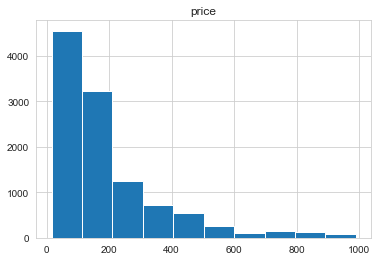

In [4]:
y.hist()

In [5]:
# Create dummy variables for 'room type', 'superhost' and 'region'
features = pd.get_dummies(features, drop_first=True)
features.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,extra_people,security_deposit,cleaning_fee,property_type_Bungalow,property_type_Condominium,...,property_type_Serviced apartment,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_t,region_East,region_North,region_South,region_West
0,2.0,2.0,4,93.0,24,30.0,500.0,100.0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,1.0,1.0,2,91.0,9,35.0,500.0,75.0,0,0,...,0,0,0,1,0,1,1,0,0,0
2,1.0,1.0,3,97.0,529,45.0,100.0,0.0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,1.0,1.0,2,98.0,257,0.0,0.0,0.0,0,0,...,0,0,0,1,0,1,0,1,0,0
4,1.0,1.0,2,99.0,112,25.0,0.0,50.0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [6]:
from sklearn.decomposition import PCA

# Set up PCA and the X vector for diminsionality reduction
pca = PCA()
df_X = features[['bathrooms', 'bedrooms', 'accommodates', 'extra_people', 'security_deposit', 'cleaning_fee']]
                #, 'review_scores_rating', 'number_of_reviews']]

# Apply PCA to the Airbnb dataset X vector
transformed_X = pca.fit_transform(df_X)

# Look at the percentage of variance explained by the different components
print(pca.explained_variance_ratio_)

[9.74470050e-01 2.23776997e-02 3.11327586e-03 3.60542580e-05
 2.14059308e-06 7.79394789e-07]


In [7]:
# Scale the quantitative features
# Note: using RobustScaler resulted in similar r2 results
scaler = MinMaxScaler()
numerical = ['bathrooms', 'bedrooms', 'accommodates', 'extra_people', 'security_deposit', 'cleaning_fee']
            #, 'review_scores_rating', 'number_of_reviews']
features_scaled = features.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [8]:
features_scaled.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,extra_people,security_deposit,cleaning_fee,property_type_Bungalow,property_type_Condominium,...,property_type_Serviced apartment,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_t,region_East,region_North,region_South,region_West
0,0.230769,0.125,0.200000,93.0,24,0.100000,0.098039,0.153846,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0.076923,0.000,0.066667,91.0,9,0.116667,0.098039,0.115385,0,0,...,0,0,0,1,0,1,1,0,0,0
2,0.076923,0.000,0.133333,97.0,529,0.150000,0.019608,0.000000,0,0,...,0,0,0,0,0,1,1,0,0,0
3,0.076923,0.000,0.066667,98.0,257,0.000000,0.000000,0.000000,0,0,...,0,0,0,1,0,1,0,1,0,0
4,0.076923,0.000,0.066667,99.0,112,0.083333,0.000000,0.076923,0,0,...,0,0,0,0,0,1,0,0,1,0


### Modeling:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, 
                                                    y, 
                                                    test_size = .30, 
                                                    random_state = 42)
                                                    #stratify=log_y)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Test set has {} samples.".format(X_test.shape[0]))

Training set has 7718 samples.
Test set has 3308 samples.


In [10]:
models = [DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 10),
          RandomForestRegressor(n_estimators=500, random_state=42)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)
    
print(results)

C:\Users\rtalebiz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


{'DecisionTreeRegressor': 0.42528489819892945, 'RandomForestRegressor': 0.5018519202817342}


In [11]:
# Import TPOTRegressor and roc_auc_score
from tpot import TPOTRegressor
from sklearn.metrics import r2_score

# Instantiate TPOTRegressor
tpot = TPOTRegressor(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='r2',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)

# AUC score for tpot model
tpot_score = r2_score(y_test, tpot.predict(X_test))
print(f'\nAUC score: {tpot_score:.4f}')

# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')

C:\Users\rtalebiz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Generation 1 - Current best internal CV score: 0.4636344663661604
Generation 2 - Current best internal CV score: 0.4636344663661604
Generation 3 - Current best internal CV score: 0.46421486679746093
Generation 4 - Current best internal CV score: 0.46421486679746093
Generation 5 - Current best internal CV score: 0.46421486679746093

Best pipeline: KNeighborsRegressor(SelectPercentile(LassoLarsCV(input_matrix, normalize=True), percentile=78), n_neighbors=59, p=2, weights=distance)

AUC score: 0.4589

Best pipeline steps:
1. StackingEstimator(estimator=LassoLarsCV(copy_X=True, cv=None,
                                        eps=2.220446049250313e-16,
                                        fit_intercept=True, max_iter=500,
                                        max_n_alphas=1000, n_jobs=None,
                                        normalize=True, positive=False,
                                        precompute='auto', verbose=False))
2. SelectPercentile(percentile=78,
               

In [12]:
# Training Decision Tree Regressor Model
modelDTR = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

modelDTR.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [13]:
X_test

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,extra_people,security_deposit,cleaning_fee,property_type_Bungalow,property_type_Condominium,...,property_type_Serviced apartment,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_t,region_East,region_North,region_South,region_West
7906,0.076923,0.000,0.200000,99.000000,21,0.016667,0.078431,0.132308,0,0,...,0,0,0,0,0,0,1,0,0,0
967,0.076923,0.000,0.066667,85.000000,4,0.166667,0.000000,0.046154,0,0,...,0,0,0,1,0,0,0,0,1,0
3694,0.153846,0.125,0.466667,100.000000,17,0.083333,0.019608,0.023077,0,0,...,0,1,0,0,0,0,1,0,0,0
8429,0.230769,0.250,0.333333,99.000000,15,0.000000,0.058824,0.230769,0,0,...,0,0,0,0,0,1,0,0,1,0
9834,0.076923,0.000,0.200000,98.000000,12,0.000000,0.000000,0.023077,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9705,0.076923,0.000,0.266667,95.972429,0,0.000000,0.000000,0.152308,0,1,...,0,0,0,0,0,0,0,0,1,0
11048,0.153846,0.000,0.066667,100.000000,6,0.016667,0.000000,0.030769,0,0,...,0,0,0,1,0,0,0,1,0,0
2014,0.076923,0.000,0.066667,90.000000,2,0.000000,0.000000,0.015385,0,1,...,0,0,0,0,0,0,1,0,0,0
9701,0.153846,0.000,0.066667,98.000000,23,0.000000,0.000000,0.046154,0,0,...,0,0,0,1,0,1,1,0,0,0


In [14]:
y_test

,price
7906,120.0
967,105.0
3694,100.0
8429,275.0
9834,75.0
...,...
9705,300.0
11048,45.0
2014,179.0
9701,40.0


In [15]:
modelDTR.score(X_test, y_test)

0.10647719803818212

In [16]:
# Accuracy score for Decision Tree
y_pred = modelDTR.predict(X_test)
cross_val_score(modelDTR, features_scaled, y, cv=10)
#print('Decision Tree Regressor accuracy: {:.2f}'.format()))

array([ 0.08447504,  0.12052424,  0.02343552,  0.1661609 , -0.07522371,
        0.01740548,  0.04683545,  0.00743164, -0.13969474, -0.17074385])

In [17]:
# Using GridSearchCV on DecisionTreeRegressor
#create a dictionary of all values we want to test
param_grid = {"max_depth": np.arange(1, 21),
              "max_features": np.arange(1, 9),
              "min_samples_leaf": [20, 40, 100],
              "min_samples_split": [10, 20, 40],
              "max_leaf_nodes": [5, 20, 100],
              #"criterion": ["mse", "mae"]
             }
#use gridsearch to test all values
dtr_cv = GridSearchCV(modelDTR, param_grid, cv=5)
#fit model to data
dtr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'max_features': array([1, 2, 3, 4, 5, 6, 7,

In [18]:
print(dtr_cv.best_params_)
print(cross_val_score(modelDTR, features_scaled, y, cv=10))

{'max_depth': 11, 'max_features': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}
[ 0.08447504  0.12052424  0.02343552  0.1661609  -0.07522371  0.01740548
  0.04683545  0.00743164 -0.13969474 -0.17074385]


In [19]:
modelDTR = DecisionTreeRegressor(max_depth= 12, max_features= 8, max_leaf_nodes=100, min_samples_leaf= 20, min_samples_split=40)
modelDTR.fit(X_train, y_train)
y_test_preds = modelDTR.predict(X_test)
print(y_test_preds)
r2_score(y_test, y_test_preds)

[128.72251309  60.2431259  119.59090909 ... 100.99509804  60.2431259
  60.2431259 ]


0.4278085198372663

##### Random Forest Regressor with Hyperparameter Tuning:

In [20]:
modelRFR = RandomForestRegressor(random_state=42)

In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': [True]
}

In [ ]:
%%time
CV_RFR = GridSearchCV(estimator=modelRFR, param_grid=param_grid, cv= 5)
CV_RFR.fit(X_train, np.ravel(y_train))

In [ ]:
CV_RFR.best_params_

In [ ]:
modelRFR=RandomForestRegressor(max_features='auto', n_estimators= 1000, max_depth=15, min_samples_split=10, min_samples_leaf=2, bootstrap=True, random_state=42)

In [ ]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [ ]:
xgb_grid.fit(X_train, y_train)

In [ ]:
xgb_grid.best_params_

In [ ]:
print("Best Params XGB MSE:", round(mean_squared_error(y_test, xgb_grid.predict(X_test)),4))
print("Best Params XGB r2:", round(r2_score(y_test, xgb_grid.predict(X_test)),4))

In [ ]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor(colsample_bytree= 0.7,
 learning_rate= 0.03,
 max_depth= 5,
 min_child_weight= 4,
 n_estimators= 500,
 nthread= 4,
 objective= 'reg:linear',
 silent= 1,
 subsample= 0.7)
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

In [ ]:
for model, result in results.items():
    #print(model, result)
    print('{} Model: {}'.format(model, result))

fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [ ]:
# models with hyperparameter tuning

models = [modelDTR,
          modelRFR,
          xgb_reg]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)
    
print(results)

In [ ]:
for model, result in results.items():
    #print(model, result)
    print('{} Model: {}'.format(model, result))

fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#325A4C', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [ ]:
# Plotly to visualize the feature importances
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
import plotly.express as px

In [ ]:
feature_importance = modelRFR.feature_importances_
feature_importance

In [ ]:
features_scaled.columns

In [ ]:
importances = pd.DataFrame({'feature': features_scaled.columns, 'importance': feature_importance}).sort_values('importance', ascending=False).reset_index(drop=True)

trace = go.Bar(x=importances.head(40).feature, y=importances.head(10).importance)

layout = go.Layout(title='Random Forest Feature Importances',
                  yaxis=dict(title='Relative Importance'))

fig = go.Figure([trace], layout)
iplot(fig, filename='feature_importance.html')

In [ ]:
feature_importance = xgb_reg.feature_importances_
feature_importance

In [ ]:
importances = pd.DataFrame({'feature': features_scaled.columns, 'importance': feature_importance}).sort_values('importance', ascending=False).reset_index(drop=True)

trace = go.Bar(x=importances.head(40).feature, y=importances.head(10).importance)

layout = go.Layout(title='XGB Feature Importances',
                  yaxis=dict(title='Relative Importance'))

fig = go.Figure([trace], layout)
iplot(fig, filename='feature_importance.html')